# Домашнее задание 10

##### Автор: [Татьяна Гайнцева](https://www.linkedin.com/in/tgaintseva/), @atmyre

В этом задании вам предстоит построить автоэнкодер, который будет сжимать и восстанавливать лица людей. Мы будем работать с тем же датасетом LFW, что был на занятии.

## Подготовка датасета

Часть подготовки датасета полностью написана, изменять ее не нужно

Импортируем нужные библиотеки:

In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### Скачивание и подготовка данных

Скачиваем данные. Мы будем обучать автоэнкодер на датасете лиц людей [Labeled faces in the Wild](http://vis-www.cs.umass.edu/lfw/) (LFW). Ячейка ниже скачивает и распаковывает датасет:

In [9]:
import urllib.request
import tarfile
import os

url = "http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz"
filename = "lfw-deepfunneled.tgz"

# Загрузка файла
urllib.request.urlretrieve(url, filename)
print("Файл загружен.")

# Разархивирование
with tarfile.open(filename, "r:gz") as tar:
    tar.extractall()
print("Файл разархивирован.")

# Удаление архива
os.remove(filename)
print("Архив удалён.")


Файл загружен.


C:\Users\vdoff\AppData\Local\Temp\ipykernel_8896\2643371879.py:14: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


Файл разархивирован.
Архив удалён.


Наши картинки скачались в папку lfw-deepfunneled. Давайте пройдемся по ней и соберем массив путей до картинок датасета:

In [12]:
import os
from PIL import Image

images = []

for dirpath, dirnames, filenames in os.walk('lfw-deepfunneled'):
    for fname in filenames:
        if fname.endswith(".jpg"):
            fpath = os.path.join(dirpath, fname)
            try:
                with Image.open(fpath) as img:  # Используем контекстный менеджер
                    images.append(img.copy())  # Копируем изображение в память
            except Exception as e:
                print(f"Ошибка при обработке файла {fpath}: {e}")

print(f"Загружено {len(images)} изображений.")


Загружено 13233 изображений.


In [13]:
len(images)

13233

Отрисуем несколько картинок, чтобы понять, с чем мы имеем дело:

In [15]:
def plot_gallery(images, n_row=3, n_col=6, from_torch=False):
    """Helper function to plot a gallery of portraits"""

    # нужно поставить from_torch=True, если функция plot_gallery
    # вызывается для images типа torch.Tensor
    if from_torch:
        images = [x.data.numpy().transpose(1, 2, 0) for x in images]

    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i])

        # убираем отрисовку координат
        plt.xticks(())
        plt.yticks(())

    plt.show()

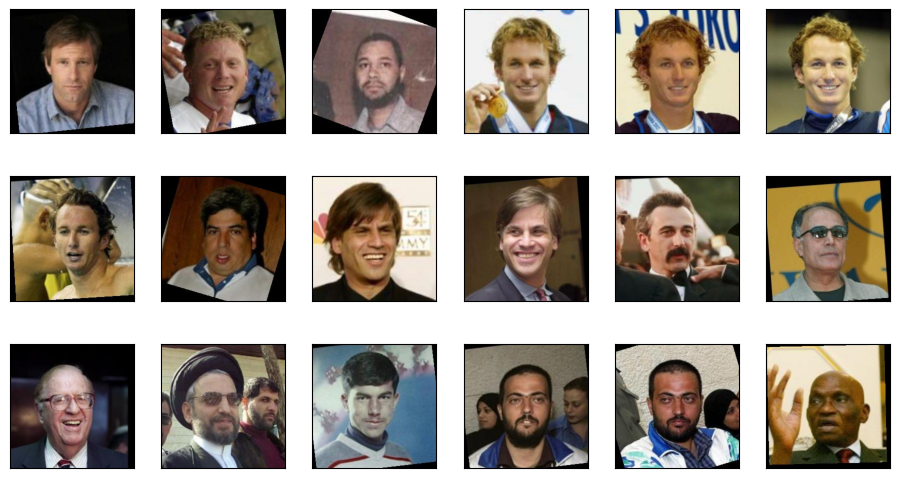

In [16]:
plot_gallery(images)

Посмотрим, какие размерности у наших картинок:

In [17]:
np.array(images[0]).shape

(250, 250, 3)

Создадим датасет Faces для работы с нашими данными:

In [19]:
class Faces(Dataset):
    def __init__(self, faces):
        self.data = faces
        self.transform = transforms.Compose([
                                    transforms.CenterCrop((90, 90)),
                                    transforms.Resize((64, 64)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                    ])

    def __getitem__(self, index):

        x = self.data[index]
        return self.transform(x).float()

    def __len__(self):
        return len(self.data)

Создадим датасет и посмотрим на несколько картинок из него:

torch.Size([3, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8666667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.7019608].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7254902..0.7882353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8117647].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8039216..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7882353].
C

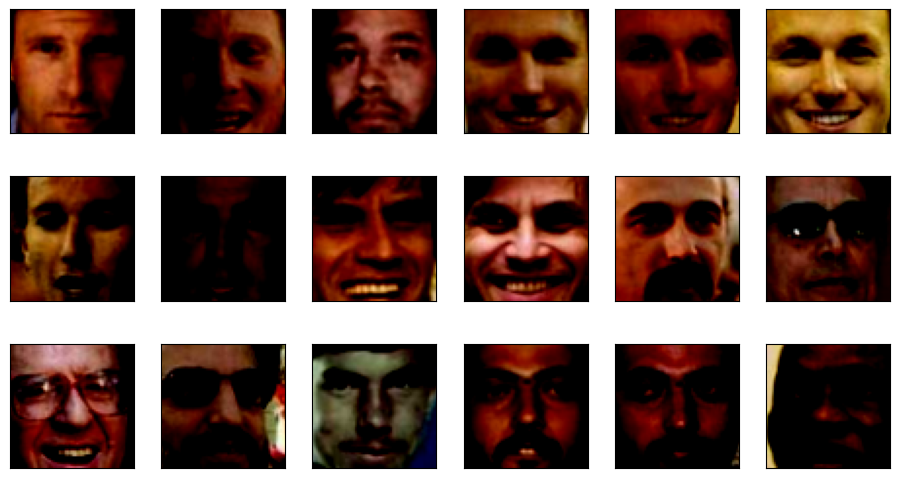

In [20]:
dataset = Faces(images)

# dataset[0] — это вызов метода __getitem__(0)
img = dataset[0]

print(img.shape)

# отрисовываем несколько картинок
plot_gallery(dataset, from_torch=True)

Делим датасет на train/val и создаем даталоадеры:

In [21]:
train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size

g_cpu = torch.Generator().manual_seed(8888)
train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size], generator=g_cpu)

In [22]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=16, shuffle=False)

## Задание: Создание модели Vanilla AE

Ваша задача — реализовать класс атоэнкодера для данных. За основу можно взять класс сети для сегментации U-Net с прошлого домашнего задания. Так как автоэнкодер — это тоже encoder-decoder архитектура, нам понадобится внести лишь немного изменений:
- В U-Net был skip connection, в автоэнкодере его быть не должно;
- Обратите внимание на то, сколько карт активации должно быть в последнем слое сети.
- в середине сети не должно быть среднего слоя, как было в U-Net

Вы можете варьировать количества блоков/слоев и устройства блоков. Архитектура блока, как в предыдущем домашнем задании (conv -> bn -> relu -> maxpool) подойдет.

In [23]:
def encoder_block(in_channels, out_channels, kernel_size, padding):
    '''
    блок, который принимает на вход карты активации с количеством каналов in_channels,
    и выдает на выход карты активации с количеством каналов out_channels
    kernel_size, padding — параметры conv слоев внутри блока
    '''
    block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=2),
        nn.ReLU(inplace=True)
    )

    return block

def decoder_block(in_channels, out_channels, kernel_size, padding):
    '''
    блок, который принимает на вход карты активации с количеством каналов in_channels,
    и выдает на выход карты активации с количеством каналов out_channels
    kernel_size, padding — параметры conv слоев внутри блока
    '''
    block = nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=2, output_padding=1),
        nn.ReLU(inplace=True)
    )

    return block

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()


        # добавьте несколько слоев encoder block
        # это блоки-составляющие энкодер-части сети
        self.encoder = nn.Sequential(
            encoder_block(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            encoder_block(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            encoder_block(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        )

        # добавьте несколько слоев decoder block
        # это блоки-составляющие декодер-части сети
        self.decoder = nn.Sequential(
            decoder_block(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            decoder_block(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            # Последний слой восстанавливает до 3 каналов для исходного формата (RGB)
            nn.ConvTranspose2d(64, 3, kernel_size=3, padding=1, stride=2, output_padding=1),
            nn.Sigmoid()  # sigmoid для нормализации выхода в [0,1], опционально
        )

    def forward(self, x):

        # downsampling
        latent = self.encoder(x)

        # upsampling
        reconstruction = self.decoder(latent)

        return reconstruction


Ячейка ниже проверяет, что модель работает правильно:

In [24]:
# проверка, что у модели есть обучаемые слои
model = Autoencoder()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
num_params = sum([np.prod(p.size()) for p in model_parameters])
assert num_params > 10

# проверка, что модель собрана верно
random_tensor = torch.Tensor(np.random.random((32, 3, 64, 64)))
model = Autoencoder()
out = model(random_tensor)
assert out.shape == (32, 3, 64, 64), "неверный размер выхода модели"

# проверка, что у модели можно отцепить декодер и использовать его как
# отдельную модель
# если здесь возникла ошибка, убедитесь, что в вашей сети нет skip connection
random_tensor = torch.Tensor(np.random.random((32, 3, 64, 64)))
model = Autoencoder()
latent_shape = model.encoder(random_tensor).shape
latent = torch.Tensor(np.random.random(latent_shape))
out = model.decoder(latent)

### Сдача задания

Если обе ячейки отработали без ошибок, можно сдавать задание в первую задачу на Я.Контесте. Для этого нужно скопировать класс Autoencoder в нужное место в submission_template10.py и отправить submission_template10.py в Я.Контест.

## Обучение модели

Теперь вы можете обучить на данных созданную вами модель. Код для этого написан ниже. В процессе обучения вы будете видеть, насколько хорошо модель учится восстанавливать лица людей.

In [27]:
from IPython.display import clear_output

stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def train(model, opt, loss_fn, epochs, train_loader, val_loader):

    for epoch in range(epochs):
        # печатаем номер текущей эпохи
        print('* Epoch %d/%d' % (epoch+1, epochs))

        # 1. Обучаем сеть на картинках из train_loader
        model.train()  # train mode

        avg_train_loss = 0
        for i, X_batch in enumerate(train_loader):
            # переносим батч на GPU
            X_batch = X_batch.to(device)
            # получаем ответы сети на батч
            Y_pred = model(X_batch)

            # считаем лосс, делаем шаг оптимизации сети
            loss = loss_fn(Y_pred, X_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()

            avg_train_loss += loss / len(train_loader)

        # выводим средний лосс на тренировочной выборке за эпоху
        print('avg train loss: %f' % avg_train_loss)

        # 2. Тестируем сеть на картинках из val_loader
        model.eval()

        avg_val_loss = 0
        for i, X_batch in enumerate(val_loader):
            # переносим батч на GPU
            X_batch = X_batch.to(device)
            # получаем ответы сети на батч
            Y_pred = model(X_batch)
            # считаем лосс на батче
            loss = loss_fn(Y_pred, X_batch)

            avg_val_loss += loss / len(val_loader)

        # выводим средний лосс на валидационных данных
        print('avg val loss: %f' % avg_val_loss)


        # 3. Визуализируем ответы сети на шести картинках из валидационных данных

        # получаем один батч из data_val
        X_val = next(iter(val_loader))
        # получаем ответ сети на картинки из батча
        Y_pred = model(X_val.to(device))
        Y_hat = Y_pred.detach().cpu().numpy()
        Y_hat = np.argmax(Y_hat, axis=1)

        # удаляем предыдущую визуализацию
        clear_output(wait=True)

        _, axes = plt.subplots(2, 6, figsize=(6*4, 2*4))
        for k in range(6):
            # отрисовываем 6 картинок, поданных на вход сети
            # картинки нормализованы, поэтому могут выглядеть непривычно
            axes[0][k].imshow(denorm(X_val[k].data.cpu().numpy()).transpose(1, 2, 0), aspect='auto')
            axes[0][k].title.set_text('Input')

            # отрисовываем ответы сети для каждого из четырех классов сегментации в отдельности
            axes[1][k].imshow(denorm(Y_pred[k].data.cpu().numpy()).transpose(1, 2, 0), aspect='auto')
            axes[1][k].title.set_text('Output')
        plt.suptitle('%d / %d - val loss: %f' % (epoch+1, epochs, avg_val_loss))
        plt.show()

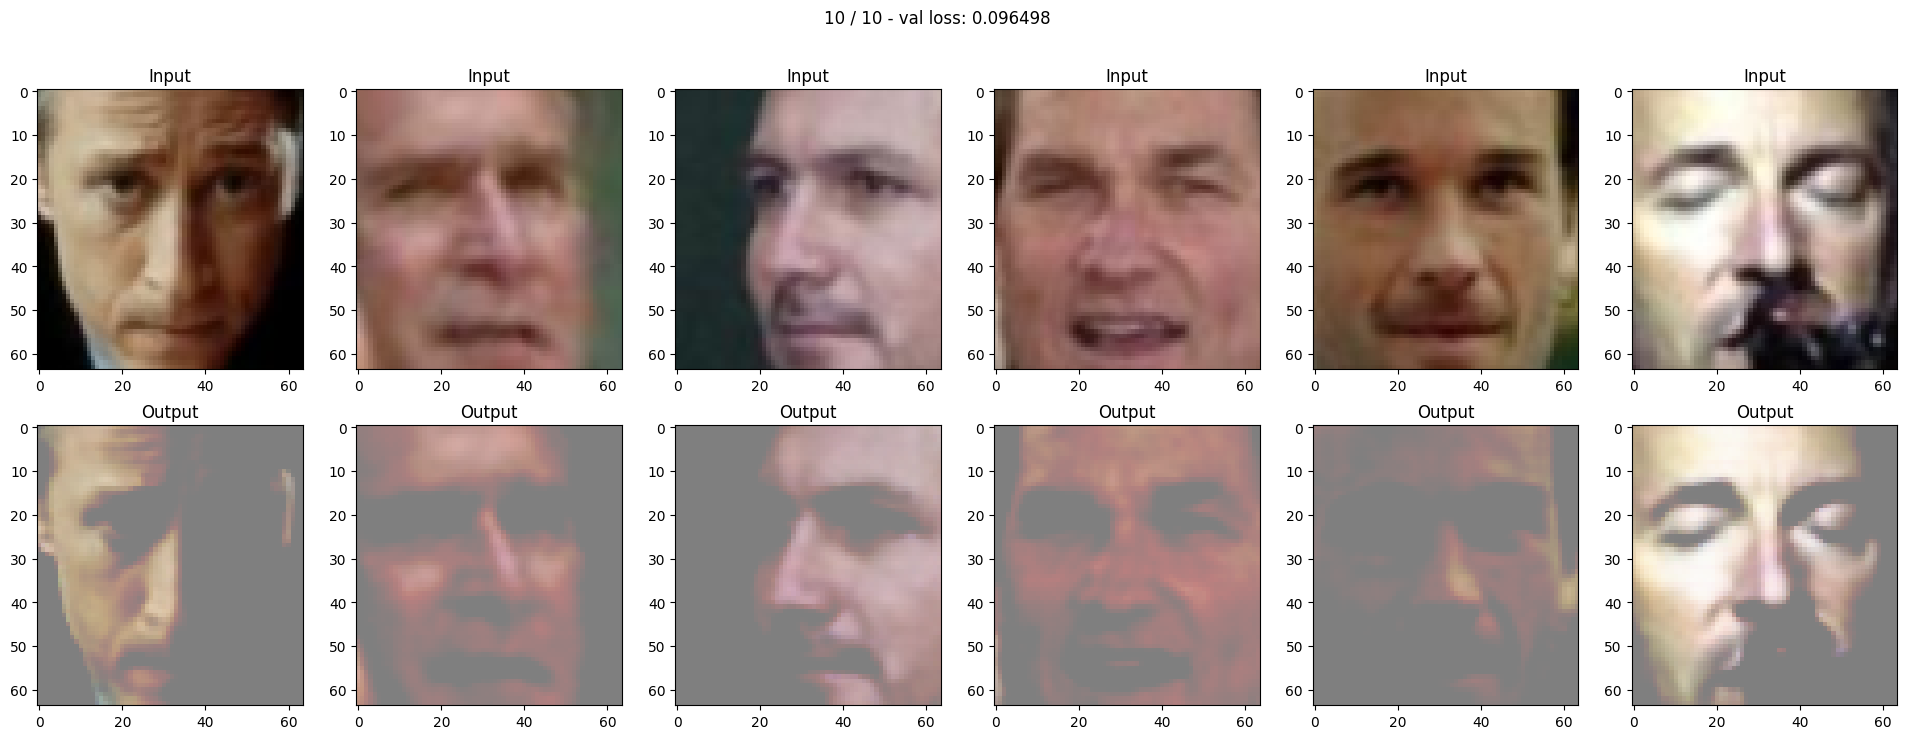

In [28]:
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

train(autoencoder, optimizer, criterion, 10, train_loader, val_loader)